In [1]:
import numpy as np
import pandas as pd
import pickle
import os
from pathlib import Path
import matplotlib.pyplot as plt
from scipy import signal
import warnings

In [2]:
warnings.simplefilter(action='ignore')

In [3]:
with open('/Users/dzisandy/Introduction-to-Data-Science/Final_Project/WESAD/S8/S8.pkl', 'rb') as f:
    data = pickle.load(f, encoding='bytes' )

In [4]:
def MSRS(data,name,f):
    i_025 = int(f*0.25)
    i_60 = int(f*60)
    i = 0
    start = 0
    end = i_60
    mean = np.empty(int((len(data) - i_60)/i_025))
    std = np.empty(int((len(data) - i_60)/i_025))
    dynamic_range = np.empty(int((len(data) - i_60)/i_025))
    slope = np.empty(int((len(data) - i_60)/i_025))
    while i*i_025 + i_60 < int(len(data)):
        mean[i] = data[start:end+1].mean()
        std[i] = data[start:end+1].std()
        dynamic_range[i] = 20*np.log10(data[start:end+1].max()/data[start:end+1].min())
        slope[i] = (float(data[end]) - float(data[start]))/i_60
        i += 1
        start = i*i_025
        end = i*i_025 + i_60
    return {'mean_{}'.format(name): mean,'std_{}'.format(name):std,'dynamic_range_{}'.format(name):dynamic_range,'slope_{}'.format(name):slope}

In [5]:
 def decompose_eda(eda):
        scr_list  = []
        b,a = signal.butter(4,0.5/2)
        gsr_filt = signal.filtfilt(b,a,eda,axis=0)
        b,a = signal.butter(4,0.5/2,'highpass')
        scr = signal.filtfilt(b,a,gsr_filt,axis=0)
        scl = [float(x-y) for x,y in zip(gsr_filt,scr)]
        for i in range(len(scr)):
            scr_list.append(scr[i][0])
        return scr_list,scl

In [6]:
def SCRL(scr,scl,f):
    scr = np.array(scr)
    scl = np.array(scl)
    i_025 = int(f*0.25)
    i_60 = int(f*60)
    i = 0
    start = 0
    end = i_60
    mean_l = np.empty(int((len(scr) - i_60)/i_025))
    mean_r = np.empty(int((len(scr) - i_60)/i_025))
    std_l = np.empty(int((len(scr) - i_60)/i_025))
    std_r = np.empty(int((len(scr) - i_60)/i_025))
    peaks = np.empty(int((len(scr) - i_60)/i_025))
    peak = np.empty(int((len(scr) - i_60)/i_025))
    out = {}
    while i*i_025 + i_60 < int(len(scr)):
        mean_r[i] = scr[start:end+1].mean()
        std_r[i] = scr[start:end+1].std()
        mean_l[i] = scl[start:end+1].mean()
        std_l[i] = scl[start:end+1].std()
        peaks[i] = len(signal.find_peaks(scr[start:end+1],height = 0 ,distance=5)[0])
        #if i % 100 ==0: 
        #    print(i)
        i += 1
        start = i*i_025
        end = i*i_025 + i_60
    return {'mean_r': mean_r,'mean_l': mean_l,'std_r':std_r,'std_l':std_l,'peaks':peaks}
    

In [7]:
def EMG(data,f):
    i_025 = int(f*0.25)
    i_5 = int(f*5)
    i = 0
    start = 0
    end = i_5
    dynamic_range = np.empty(int((len(data) - i_5)/i_025))
    mean = np.empty(int((len(data) - i_5)/i_025))
    std = np.empty(int((len(data) - i_5)/i_025))
    while i*i_025 + i_5 < int(len(data)):
        mean[i] = data[start:end+1].mean()
        std[i] = data[start:end+1].std()
        #print(data[start:end+1].max(), data[start:end+1].min())
        dynamic_range[i] = 20*np.log(abs(data[start:end+1].max())/abs(data[start:end+1].min()))
        #if i % 100 ==0: 
        #    print(i)
        i += 1
        start = i*i_025
        end = i*i_025 + i_5
    return {'mean': mean, 'std':std, 'dynamic_range': dynamic_range}
        
    

In [8]:
Temp_chest = MSRS(data[b'signal'][b'chest'][b'Temp'],'Temp_chest',700)
#Temp_chest

In [9]:
Temp_wrist = MSRS(data[b'signal'][b'wrist'][b'TEMP'],'Temp_wrist',4)
#Temp_wrist

In [10]:
EDA_chest = MSRS(data[b'signal'][b'chest'][b'EDA'],'Temp_chest',700)
#EDA_chest

In [11]:
EDA_wrist = MSRS(data[b'signal'][b'wrist'][b'EDA'],'Temp_wrist',4)
#EDA_wrist

In [12]:
scr_chest, scl_chest = decompose_eda(data[b'signal'][b'chest'][b'EDA'])

In [13]:
scr_wrist, scl_wrist = decompose_eda(data[b'signal'][b'wrist'][b'EDA'])

In [14]:
SCRL_chest = SCRL(scr_chest,scl_chest,700)
#SCRL_chest

In [15]:
SCRL_wrist = SCRL(scr_wrist,scl_wrist,4)
#SCRL_wrist

In [16]:
EMG_chest = EMG(data[b'signal'][b'chest'][b'EMG'], 700)
#EMG_chest

Due to the fact, that we have a raw data from two sensor devices, feature generation is vital. Using raw data of sensor channels we will go into details of feature creation. From raw data we use several columns: EDA, EMG, TEMP from either wirst or chest sensor. Let's describe feature generation for every column separately. But for most features generation process has one thing in common: it's done with a sliding window, with a window shift of 0.25 seconds. Raw signals segmented into 1-minute window (Instead of 1-minute window EMG data is processed with 5-seconds window).

Let's start with TEMP data: It's temperature, being mesuared in °C, so for that column we provide some ordinary features. This features are:  mean value, standart deviation, dynamic range, slope for every window.

Secondly, let's review EMG data feature processing. EMG data represents Electromyography, measured in mV. As mentioned above, this feature process was handled with special 5-seconds window. For this data were generated same features as for Temper ature column: mean value, standart deviation, dynamic range for every window.

Thirdly, EDA data is Electrodermal activity, measured in µS. For raw data mean value, standart deviation, dynamic range, slope for every window were processed. After some paper research we discovered the fact, that we can separate EDA into SCL and SCR. The EDA complex includes both background tonic (skin conductance level: SCL) and rapid phasic components (Skin Conductance Responses: SCRs) that result from sympathetic neuronal activity. So after separation, we generated mean and standart deviation features for both parts. For SCR component we processed interesting feature: number of peaks for every window. Generation of this feature represented in plot below.

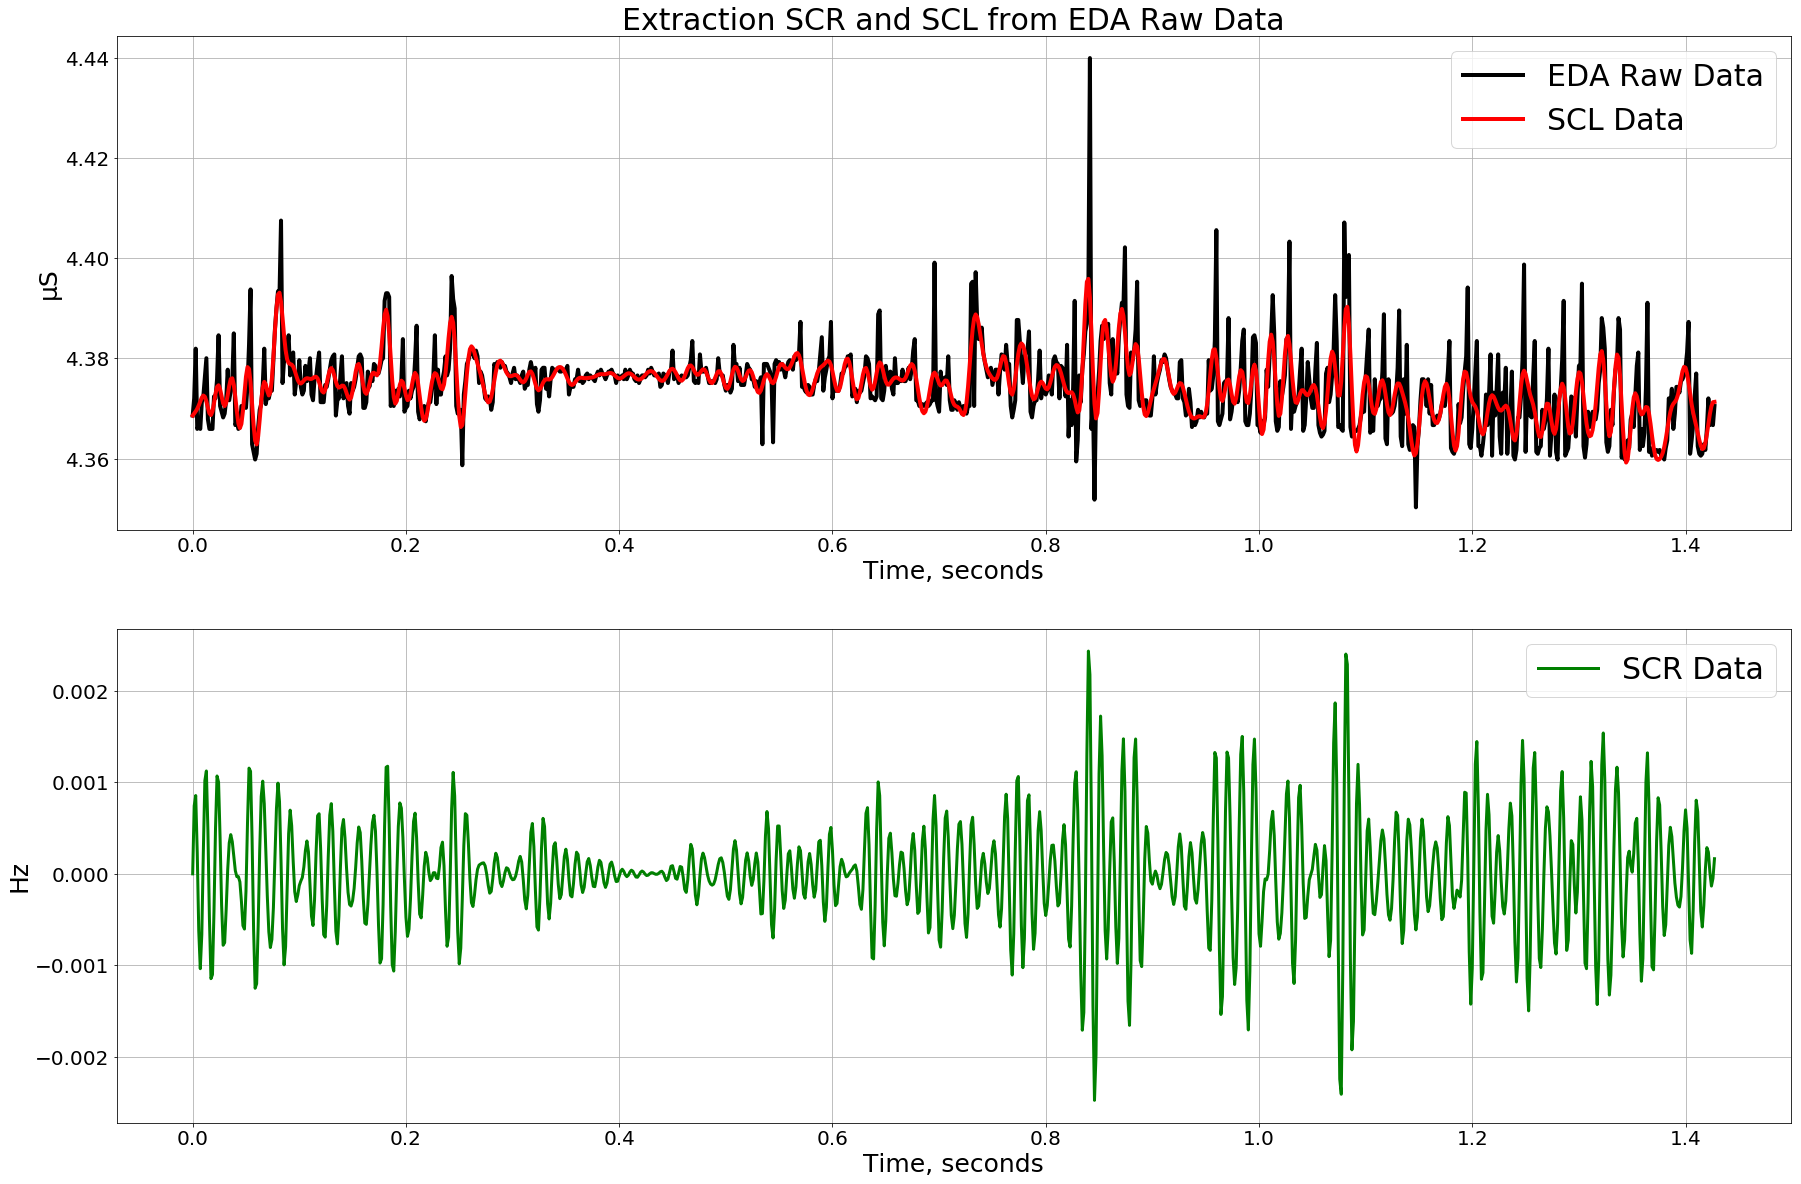

In [90]:
x = np.arange(len(data[b'signal'][b'chest'][b'EDA'][0:1000]))*1/700
plt.figure(figsize=(30,20))
plt.subplot(2, 1, 1)
plt.title('Extraction SCR and SCL from EDA Raw Data', fontsize = 30)
plt.grid(True)
plt.plot(x, data[b'signal'][b'chest'][b'EDA'][0:1000], color = 'black', lw = 4, label = 'EDA Raw Data')
plt.plot(x, scl_chest[0:1000], color = 'red', lw = 4, label = 'SCL Data')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel('µS', fontsize = 25)
plt.xlabel('Time, seconds', fontsize = 25)
plt.legend(prop={'size': 30})
plt.subplot(2, 1, 2)
plt.plot(x, scr_chest[0:1000], color = 'green', lw = 3, label = 'SCR Data')
plt.grid(True)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Time, seconds', fontsize = 25)
plt.ylabel('Hz', fontsize = 25)
plt.legend(prop={'size': 30})
plt.show()



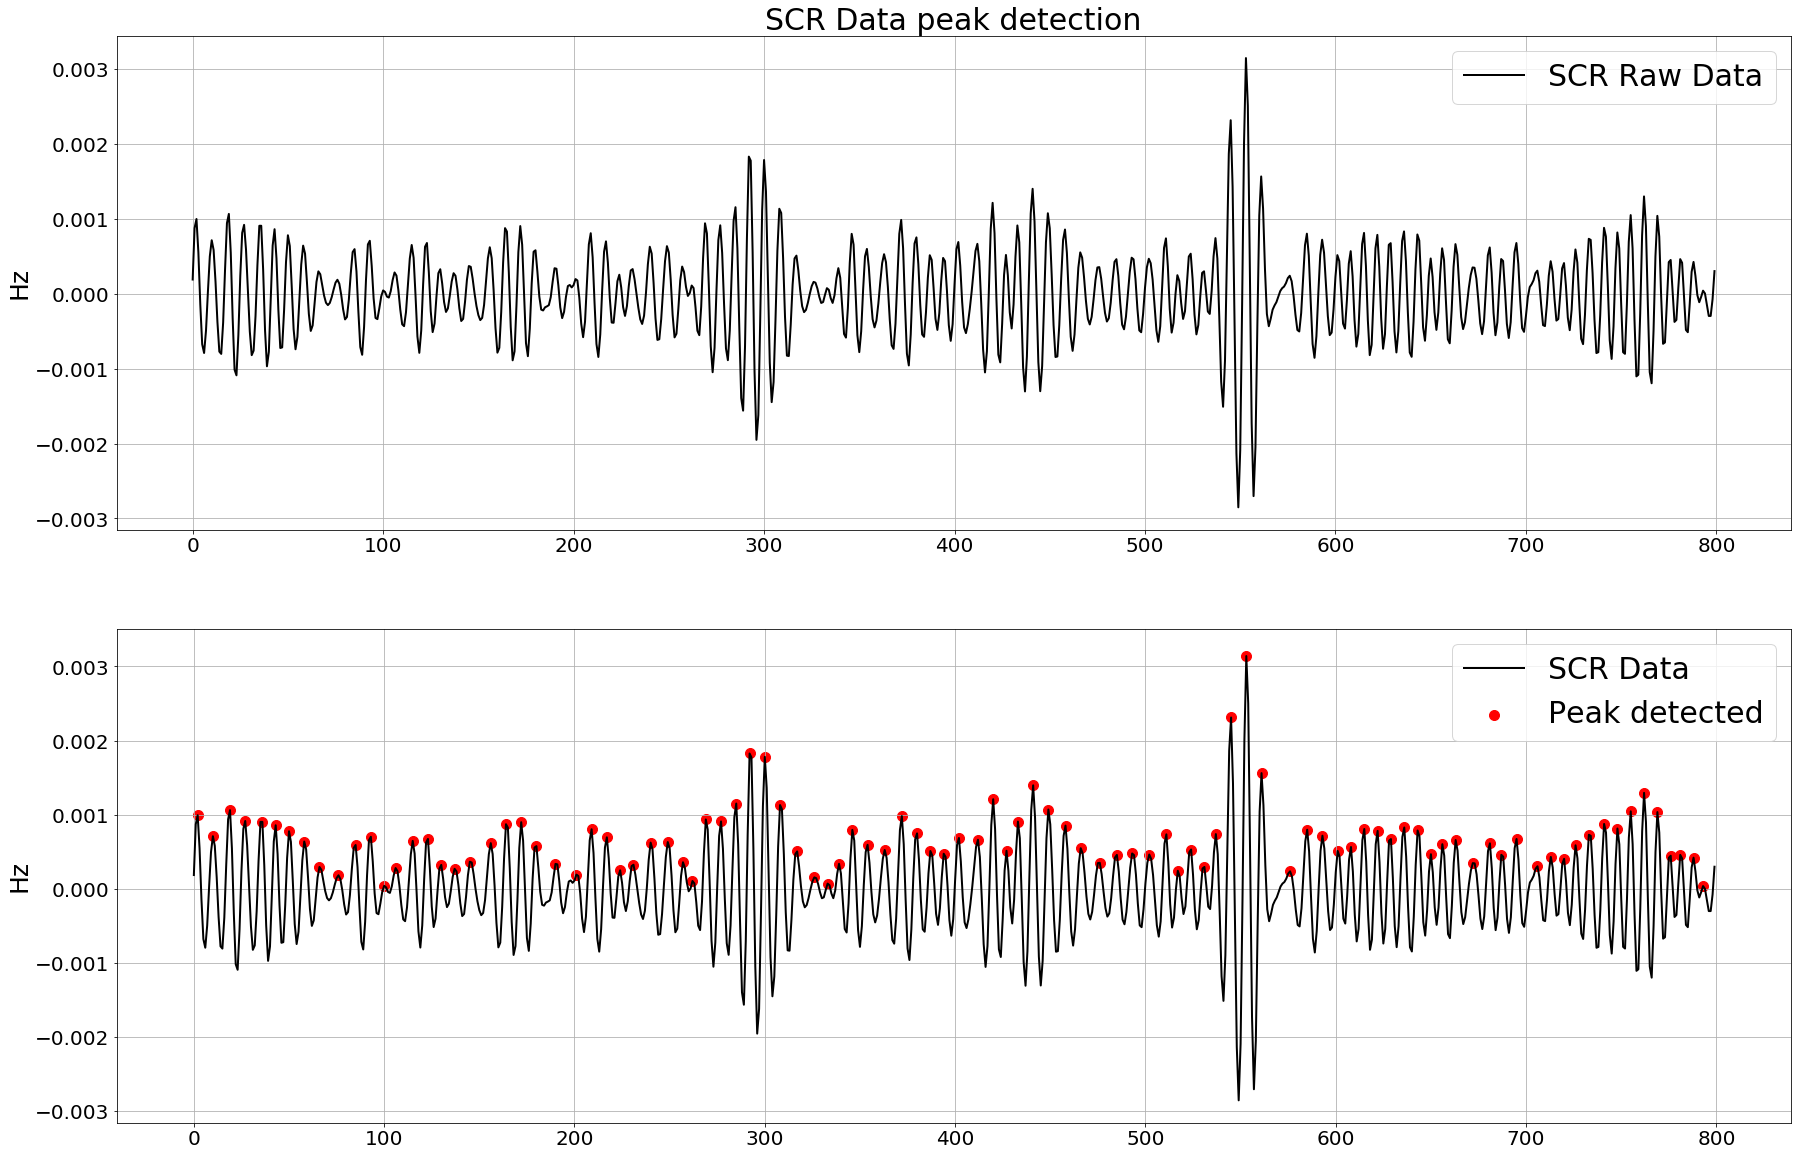

In [112]:
plt.figure(figsize=(30,20))
plt.subplot(2, 1, 1)
plt.title('SCR Data peak detection', fontsize = 30)
plt.grid(True)
peaks = signal.find_peaks(scr_chest[1600:2400], height = 0 ,distance=5)
plt.plot(scr_chest[1600:2400], color = 'black', lw = 2, label = 'SCR Raw Data')
plt.ylabel('Hz', fontsize = 25)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.legend(prop={'size': 30})
plt.subplot(2, 1, 2)
peaks = signal.find_peaks(scr_chest[1600:2400], height = 0 ,distance=5)
plt.plot(scr_chest[1600:2400], color = 'black', lw = 2, label = 'SCR Data')
plt.scatter(peaks[0], peaks[1]['peak_heights'], color = 'red', s =100, label = 'Peak detected')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel('Hz', fontsize = 25)
plt.grid(True)
plt.legend(prop={'size': 30})
plt.show()

